In [1]:
# Setting for Notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
gold_row = yf.download('GLD', '2021-01-01', '2022-08-26', auto_adjust=True)
# Only keep close columns
gold = gold_row[['Close']]
gold.describe()
gold.tail()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2022-08-19,162.720001
2022-08-22,161.639999
2022-08-23,162.770004
2022-08-24,163.250000
2022-08-25,163.750000


In [3]:
def quick_analysis(df):
    print("Data Types:")
    print(df.dtypes)
    print("Rows and Columns:")
    print(df.shape)
    print("Column Names:")
    print(df.columns)
    print("Null Values:")
    print(df.apply(lambda x: sum(x.isnull())))
quick_analysis(gold_row)

Data Types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
Rows and Columns:
(415, 5)
Column Names:
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Null Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


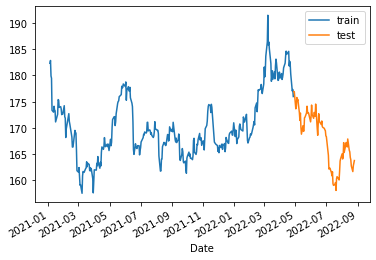

In [4]:
# Split the Close data into train and test dataset - 80% / 20%
import random
gold.sample(frac = 1)
t = .8
t = int(t*len(gold))

train = gold.dropna()[:t]
test = gold.dropna()[t:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])


In [6]:
# Define dependent variable - shifted prices for 15 days
for i in range(0, 30):
    train['shift_{}'.format(i)] = train['Close'].shift(i)
    test['shift_{}'.format(i)] = test['Close'].shift(i)

In [7]:
#Redifine train and test sets

X_train = train.dropna().drop('Close', axis=1)
y_train = train.dropna()[['Close']]

X_test = test.dropna().drop('Close', axis=1)
y_test = test.dropna()[['Close']]


In [8]:
X_train_t = X_train.values.reshape(X_train.values.shape[0], 30, 1)
X_test_t = X_test.values.reshape(X_test.values.shape[0], 30, 1)
X_train_t.shape

(303, 30, 1)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
import random as python_random
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

In [24]:
model = Sequential()
model.add(LSTM(100, input_shape=(30,1), activation='gelu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train_t, y_train, epochs=1000, batch_size=128)

Epoch 1/1000
3/3 [==============================] - 2s 51ms/step - loss: 36449.0898
Epoch 2/1000
3/3 [==============================] - 0s 53ms/step - loss: 26199.6992
Epoch 3/1000
3/3 [==============================] - 0s 59ms/step - loss: 33540.3750
Epoch 4/1000
3/3 [==============================] - 0s 48ms/step - loss: 96376.5781
Epoch 5/1000
3/3 [==============================] - 0s 58ms/step - loss: 141113.0781
Epoch 6/1000
3/3 [==============================] - 0s 48ms/step - loss: 65315.2891
Epoch 7/1000
3/3 [==============================] - 0s 58ms/step - loss: 72937.7266
Epoch 8/1000
3/3 [==============================] - 0s 52ms/step - loss: 97336.8750
Epoch 9/1000
3/3 [==============================] - 0s 59ms/step - loss: 44972.3984
Epoch 10/1000
3/3 [==============================] - 0s 59ms/step - loss: 11709.9336
Epoch 11/1000
3/3 [==============================] - 0s 58ms/step - loss: 10080.7021
Epoch 12/1000
3/3 [==============================] - 0s 63ms/step - loss:

In [26]:
model.evaluate(X_test_t, y_test, batch_size=64)

1/1 [==============================] - 0s 219ms/step - loss: 1.9230


1.92303466796875

In [27]:
y_pred = model.predict(X_test_t, batch_size=32)
compare = pd.DataFrame({'test' : y_test.Close.values,
             'pred' : y_pred.reshape(-1)})

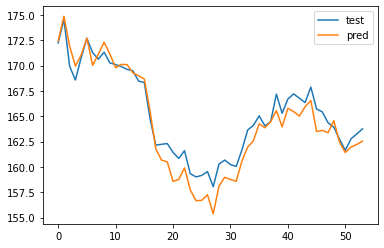

In [28]:
ax = compare.plot()
plt.legend(['test', 'pred'])

In [29]:
arr = []
data = X_test_t[-1].reshape(-1)

for i in range(29):
    y_pred = model.predict(data.reshape(1,-1,1), batch_size=32)
    y_pred = y_pred.reshape(-1)[0]
    data = np.roll(data,1)
    arr.append(y_pred)
arr.insert(0, y_test.Close[-1])
arr

[163.75,
 162.53625,
 158.54662,
 158.76917,
 158.19537,
 156.33994,
 156.97072,
 159.20903,
 159.04062,
 158.71298,
 160.79546,
 161.88774,
 162.43956,
 163.68422,
 164.65057,
 164.9987,
 166.8678,
 163.48166,
 165.66522,
 165.56854,
 164.96019,
 165.8679,
 166.57979,
 163.53297,
 163.59447,
 163.36789,
 164.5793,
 162.44014,
 161.4035,
 161.9508]

In [32]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
X = []
start_date = date(2022, 8, 26)
end_date = date(2022, 9, 25)
for single_date in daterange(start_date, end_date):
    X.append(single_date.strftime("%Y-%m-%d"))
Y = [pd.Timestamp(i) for i in X]
Y

[Timestamp('2022-08-26 00:00:00'),
 Timestamp('2022-08-27 00:00:00'),
 Timestamp('2022-08-28 00:00:00'),
 Timestamp('2022-08-29 00:00:00'),
 Timestamp('2022-08-30 00:00:00'),
 Timestamp('2022-08-31 00:00:00'),
 Timestamp('2022-09-01 00:00:00'),
 Timestamp('2022-09-02 00:00:00'),
 Timestamp('2022-09-03 00:00:00'),
 Timestamp('2022-09-04 00:00:00'),
 Timestamp('2022-09-05 00:00:00'),
 Timestamp('2022-09-06 00:00:00'),
 Timestamp('2022-09-07 00:00:00'),
 Timestamp('2022-09-08 00:00:00'),
 Timestamp('2022-09-09 00:00:00'),
 Timestamp('2022-09-10 00:00:00'),
 Timestamp('2022-09-11 00:00:00'),
 Timestamp('2022-09-12 00:00:00'),
 Timestamp('2022-09-13 00:00:00'),
 Timestamp('2022-09-14 00:00:00'),
 Timestamp('2022-09-15 00:00:00'),
 Timestamp('2022-09-16 00:00:00'),
 Timestamp('2022-09-17 00:00:00'),
 Timestamp('2022-09-18 00:00:00'),
 Timestamp('2022-09-19 00:00:00'),
 Timestamp('2022-09-20 00:00:00'),
 Timestamp('2022-09-21 00:00:00'),
 Timestamp('2022-09-22 00:00:00'),
 Timestamp('2022-09-

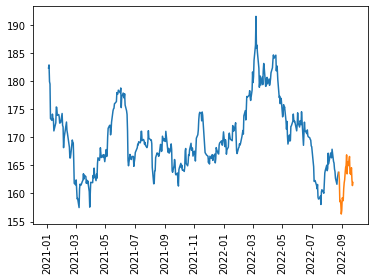

In [34]:
plt.plot(gold_row['Close'])
plt.xticks(rotation=90)
plt.plot(Y[:],arr[:])